In [313]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
from xbbg import blp
from sklearn.decomposition import PCA
pd.options.display.float_format = '{:,.3f}'.format
from collections import namedtuple
from dateutil.relativedelta import relativedelta
from datetime import date, datetime, timedelta
import pandas_datareader.data as pdr
from pandas_datareader.fred import FredReader
import seaborn as sns

In [290]:
# FRED CMT data
tickers = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
tenors = [1, 2, 3, 5, 7, 10, 20, 30] # => charts scale
#tenors = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']

lb_period = 1
end_date = datetime.today() # custom datetime(YYYY,MM,DD)
start_date = end_date - relativedelta(years=lb_period)
freq = 'D' # D/W/M
# level = False # True for level pca and False for change pca
# scaling = False 

def data_fred(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tickers:
        reader = FredReader(ticker, start_date, end_date)
        df0 = reader.read()
        df = df.merge(df0, how='outer', left_index=True, right_index=True, sort=False)
    df.dropna(axis = 0, inplace = True)
    df.tail(3)
    return df

df = data_fred(tickers, start_date, end_date)
df

,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,
2021-03-10,0.080,0.160,0.320,0.800,1.200,1.530,2.150,2.240
2021-03-11,0.080,0.140,0.310,0.780,1.200,1.540,2.180,2.290
2021-03-12,0.090,0.140,0.340,0.850,1.300,1.640,2.310,2.400
2021-03-15,0.080,0.140,0.330,0.840,1.280,1.620,2.270,2.370
2021-03-16,0.070,0.150,0.330,0.830,1.280,1.620,2.300,2.380
...,...,...,...,...,...,...,...,...
2022-03-01,0.910,1.310,1.470,1.560,1.670,1.720,2.190,2.110
2022-03-02,1.060,1.500,1.670,1.740,1.830,1.860,2.320,2.240
2022-03-03,1.080,1.530,1.690,1.740,1.820,1.860,2.320,2.240


In [ ]:
# BBG Data

tickers = ['EESWE1 Curncy', 'EESWE2 Curncy', 'EESWE3 Curncy', 'EESWE5 Curncy', 'EESWE7 Curncy', 'EESWE10 Curncy', 'EESWE20 Curncy','EESWE30 Curncy']
tenors = [1, 2, 3, 5, 7, 10, 20, 30] # => charts scale

lb_period = 1
end_date = datetime.today() # custom datetime(YYYY,MM,DD)
start_date = end_date - relativedelta(years=lb_period)
freq = 'D' # D/W/M
# level = False # True for level pca and False for change pca
# scaling = False 

def data_bbg(tickers, start_date, end_date):
    df = blp.bdh(tickers=tickers, flds=['PX_LAST'], start_date=start_date, end_date=end_date)
    df.columns = tickers # rename cols
    return df

df = data_bbg(tickers, start_date, end_date)
df

In [292]:
# pca function

def run_pca(df):
    df_daily = df.resample(freq).last()
    df_daily.dropna(axis = 0, inplace = True) # remove NA rows from .resample

    df_daily_diff = df_daily.diff().multiply(100) # calc change and convert into bps from %
    df_daily_diff.dropna(axis = 0, inplace=True)
    df_daily_diff_centered = df_daily_diff.sub(df_daily_diff.mean()) # calc de-meaned 
    
    pca_change = PCA().fit(df_daily_diff)
    
    df_pca_change = pca_change.transform(df_daily_diff) # score matrix
    df_pca_change = pd.DataFrame(df_pca_change, columns=[f'PC_{x+1}' for x in range(df_pca_change.shape[1])])
    df_pca_change.index = df_daily_diff.index
    
    W = pd.DataFrame(pca_change.components_.T)
    W.columns = [f'PC_{i+1}' for i in range(W.shape[1])]
    W.index = tickers
    
    return df_daily, df_daily_diff, df_daily_diff_centered, pca_change, df_pca_change, W


Cumulative Exp 
 [0.81241156 0.94718834 0.97576803 0.985749   0.99182285 0.99541811
 0.99809897 1.        ]


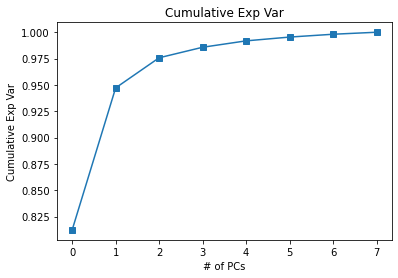

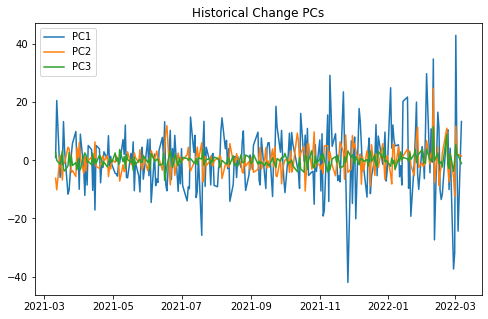

Loadings 
        PC_1   PC_2   PC_3
DGS1  0.162  0.360  0.718
DGS2  0.269  0.494  0.187
DGS3  0.333  0.423 -0.124
DGS5  0.402  0.195 -0.418
DGS7  0.425 -0.020 -0.299
DGS10 0.418 -0.209 -0.086
DGS20 0.376 -0.396  0.213
DGS30 0.364 -0.456  0.343


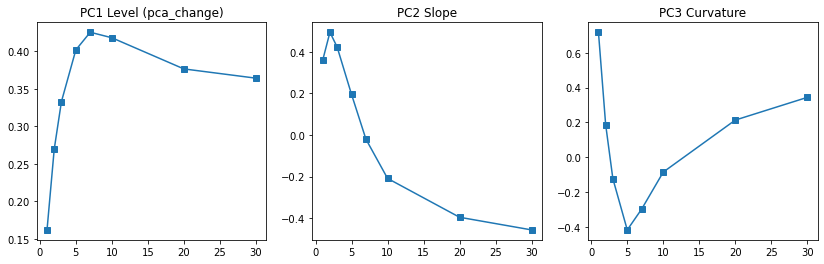

In [294]:
#
df_daily, df_daily_diff, df_daily_diff_centered, pca_change, df_pca_change, W = run_pca(df)

print("Cumulative Exp \n", pca_change.explained_variance_ratio_.cumsum())
plt.plot(pca_change.explained_variance_ratio_.cumsum(),"-s");
plt.title("Cumulative Exp Var")
plt.xlabel('# of PCs');
plt.ylabel('Cumulative Exp Var');

# plot historical PCs
plt.figure(figsize=(8,5))
plt.title("Historical Change PCs") 
plt.plot(df_pca_change['PC_1'], label='PC1')
plt.plot(df_pca_change['PC_2'], label='PC2')
plt.plot(df_pca_change['PC_3'], label='PC3')
plt.legend()
plt.show();


print('Loadings \n', W.iloc[:,0:3]); # loadings/weights matrix - what was plotted below

# plot the loadings vs tenor
plt.figure(figsize=(14,4)) 
plt.subplot(131, title = "PC1 Level (pca_change)")
plt.plot(tenors, W.T.iloc[0, :], "-s");
plt.subplot(132, title = "PC2 Slope")
plt.plot(tenors, W.T.iloc[1, :], "-s");
plt.subplot(133, title = "PC3 Curvature")
plt.plot(tenors, W.T.iloc[2, :], "-s");

Loadings 
       DGS1  DGS2   DGS3   DGS5   DGS7  DGS10  DGS20  DGS30
PC_1 0.162 0.269  0.333  0.402  0.425  0.418  0.376  0.364
PC_2 0.360 0.494  0.423  0.195 -0.020 -0.209 -0.396 -0.456
PC_3 0.718 0.187 -0.124 -0.418 -0.299 -0.086  0.213  0.343
Loadings2 
       DGS1  DGS2  DGS3   DGS5   DGS7  DGS10  DGS20  DGS30
PC_1 0.023 0.094 0.177  0.329  0.421  0.461  0.490  0.470
PC_2 0.008 0.332 0.420  0.512  0.291  0.008 -0.328 -0.510
PC_3 0.131 0.749 0.327 -0.196 -0.372 -0.170  0.025  0.331


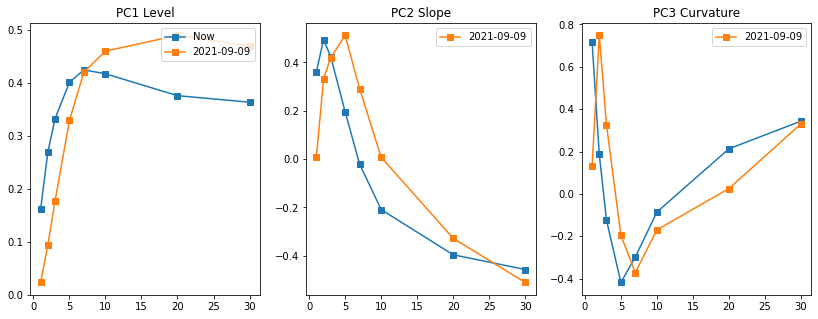

In [304]:
# look at how PCs chnage over time

today = datetime.today()
end_date2 = today - relativedelta(months=6)
start_date2 = end_date2 - relativedelta(years=lb_period)

#df2 = data_bbg(tickers, start_date2, end_date2)
df2 = data_fred(tickers, start_date2, end_date2)
#df2.tail()

df_daily2, df_daily2_diff, df_daily2_diff_centered, pca_change2, df_pca_change2, W2 = run_pca(df2)

W2['PC_1'] = W2['PC_1'] #* -1  #if need to convert signs
W2['PC_3'] = W2['PC_3'] * -1
#print(W2)

print('Loadings \n', W.T.iloc[0:3,:]);
print('Loadings2 \n', W2.T.iloc[0:3,:]);

plt.figure(figsize=(14,5));

plt.subplot(131, title = "PC1 Level")
plt.plot(tenors, W.T.iloc[0, :], "-s", label='Now');
plt.plot(tenors, W2.T.iloc[0, :], "-s", label=end_date2.strftime('%Y-%m-%d'));
plt.legend(loc="upper right");

plt.subplot(132, title = "PC2 Slope", label='Now')
plt.plot(tenors, W.T.iloc[1, :], "-s");
plt.plot(tenors, W2.T.iloc[1, :], "-s", label=end_date2.strftime('%Y-%m-%d'));
plt.legend(loc="upper right");

plt.subplot(133, title = "PC3 Curvature", label='Now')
plt.plot(tenors, W.T.iloc[2, :], "-s");
plt.plot(tenors, W2.T.iloc[2, :], "-s", label=end_date2.strftime('%Y-%m-%d'));
plt.legend(loc="upper right");

In [299]:
# Map dv01 risk to PC risk via W_T * nom_risk = pc_risk

tickers = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
tenors = [1, 2, 3, 5, 7, 10, 20, 30]

risk_dict = {
    '1Y':0,
    '2Y':1,
    '3Y':0,
    '5Y':-2,
    '7Y':0,
    '10Y':1,
    '20Y':0,  
    '30Y':0}

def risk_map(risk_dict, pca_change):
    nom_risk = np.fromiter(risk_dict.values(), dtype=float) # 8x1 array
    pc_risk = np.matmul(pca_change.components_[0:3,:],nom_risk) # 3x8 * 8x1 = 3x1 result
    return nom_risk, pc_risk

nom_risk, pc_risk = risk_map(risk_dict, pca_change)

print('nom_risk \n', pd.DataFrame(nom_risk,tenors, columns =['DV01']))
print('PC_risk \n', pd.DataFrame(pc_risk, ['PC1','PC2','PC3'], columns =['PC01']))

nom_risk 
      DV01
1   0.000
2   1.000
3   0.000
5  -2.000
7   0.000
10  1.000
20  0.000
30  0.000
PC_risk 
       PC01
PC1 -0.116
PC2 -0.105
PC3  0.938


In [300]:
# Residual analysis: given time period and net change per tenor, show calculated PC explained/residual

exp_pcs = 3
chg_dict = { # in bps
    '1Y':7,
    '2Y':10,
    '3Y':12,
    '5Y':12,
    '7Y':15,
    '10Y':10,
    '20Y':9,  
    '30Y':6}

def res_calc(df_daily_diff, exp_pcs, chg_dict, pca_change):
    chg_arr = np.fromiter(chg_dict.values(), dtype=float)
    chg_arr_cen = chg_arr - df_daily_diff.mean().to_numpy() # center the array
    
    # W * W_T * chg_arr_cen to project CoD to to PC123 subspace in normal coordinates
    pc_score = np.matmul(pca_change.components_[0:exp_pcs,:],chg_arr_cen)
    exp_bps = np.matmul(pca_change.components_.T[:,0:exp_pcs],pc_score) # exp_bps is centered
    res_bps = chg_arr_cen - exp_bps # so use chg_arr_cen
    
    return chg_arr, pc_score, exp_bps, res_bps
    
chg_arr, pc_score, exp_bps, res_bps = res_calc(df_daily_diff, exp_pcs, chg_dict, pca_change)

d = {'Actual': chg_arr, 'Exp': exp_bps+df_daily_diff.mean().to_numpy(), 'Res': res_bps, 'check':res_bps+exp_bps+df_daily_diff.mean().to_numpy()}

print('pc_score of actual \n', pc_score)
print(pd.DataFrame(data=d, index = tickers)) # positive res = CoD too high vs model


pc_score of actual 
 [28.06694405  5.51117689 -1.06864791]
       Actual    Exp    Res  check
DGS1    7.000  6.168  0.832  7.000
DGS2   10.000 10.646 -0.646 10.000
DGS3   12.000 12.349 -0.349 12.000
DGS5   12.000 13.156 -1.156 12.000
DGS7   15.000 12.366  2.634 15.000
DGS10  10.000 10.765 -0.765 10.000
DGS20   9.000  8.209  0.791  9.000
DGS30   6.000  7.313 -1.313  6.000


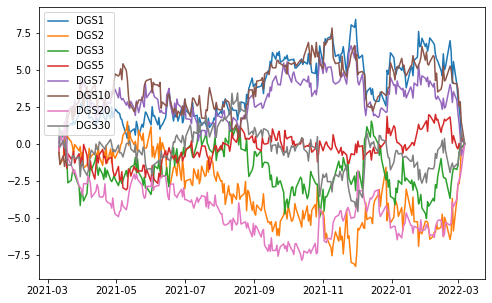

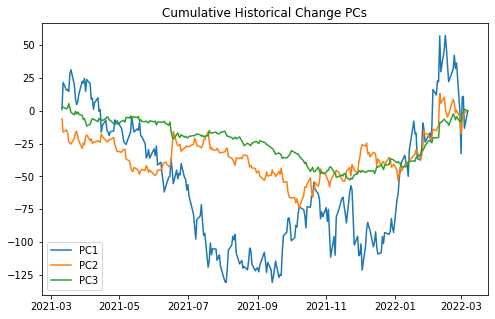

In [301]:
# residual analysis 2: cumulative tenor residual moved this year
# take each row of chg data, start with first row (get score, calc exp and res) then merge

# this need more looking into

exp_pcs = 3

y = []

for i in range(0,len(df_daily_diff_centered.index)):
    chg_arr = df_daily_diff_centered.iloc[i,].to_numpy()
    pc_score = np.matmul(pca_change.components_[0:exp_pcs,:],chg_arr)
    exp_bps = np.matmul(pca_change.components_.T[:,0:exp_pcs],pc_score) # exp_bps is centered
    res_bps = chg_arr - exp_bps # so use chg_arr_cen
    y.append(res_bps)

df_daily_res = pd.DataFrame(y, columns = tickers, index = df_daily_diff_centered.index)
df_daily_res_sum = df_daily_res.cumsum()
df_daily_res_sum.tail(5)

plt.figure(figsize=(8,5))
plt.plot(df_daily_res_sum)
plt.legend(tickers, loc = "upper left")
plt.show()

df_pca_change_sum = df_pca_change.cumsum()
plt.figure(figsize=(8,5))
plt.title("Cumulative Historical Change PCs") 
plt.plot(df_pca_change_sum['PC_1'], label='PC1')
plt.plot(df_pca_change_sum['PC_2'], label='PC2')
plt.plot(df_pca_change_sum['PC_3'], label='PC3')
plt.legend()
plt.show();


# positive res = CoD too high vs model
#check cumulative bp residual per tenor, see how mean reverting that is...need to check why cumulative sum = 0 
#check cumulative PC3 residual, see how mean reverting that is

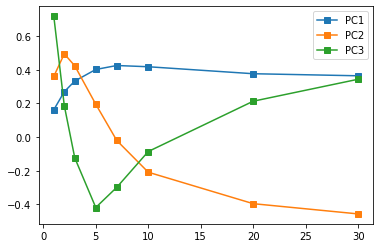

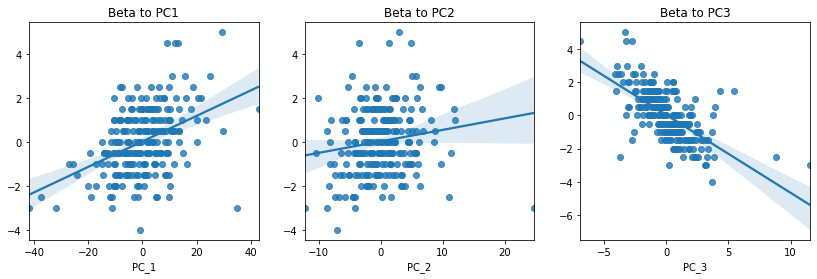

In [305]:
# PC analysis of conventional flies

# tickers = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']

belly = 'DGS5'
w_short = 'DGS2'
w_long = 'DGS10'

plt.figure(figsize=(6,4)) 
plt.plot(tenors, W.T.iloc[0, :], "-s", label='PC1');
plt.plot(tenors, W.T.iloc[1, :], "-s", label='PC2');
plt.plot(tenors, W.T.iloc[2, :], "-s", label='PC3');
plt.legend(loc='upper right');

fly55 = df_daily_diff[belly] - (df_daily_diff[w_short] + df_daily_diff[w_long])*0.5 # easier for ratio

plt.figure(figsize=(14,4))
plt.subplot(131, title = "Beta to PC1")
sns.regplot(x=df_pca_change['PC_1'], y=fly55);
plt.subplot(132, title = "Beta to PC2")
sns.regplot(x=df_pca_change['PC_2'], y=fly55);
plt.subplot(133, title = "Beta to PC3")
sns.regplot(x=df_pca_change['PC_3'], y=fly55);

0.05790955894647609 0.05229606543793611
pca weights short/long 
 0.6291614003204069 0.5553087884500439


<Figure size 1008x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='PC_1'>

<AxesSubplot:>

<AxesSubplot:xlabel='PC_2'>

<AxesSubplot:>

<AxesSubplot:xlabel='PC_3'>

,fly55,flypca
DATE,,
2022-03-01,0.090,-0.439
2022-03-02,0.120,-0.473
2022-03-03,0.090,-0.511
2022-03-04,0.060,-0.520
2022-03-07,0.090,-0.507


<Figure size 720x288 with 0 Axes>

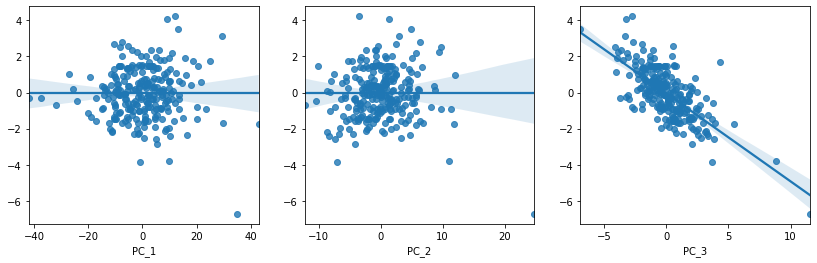

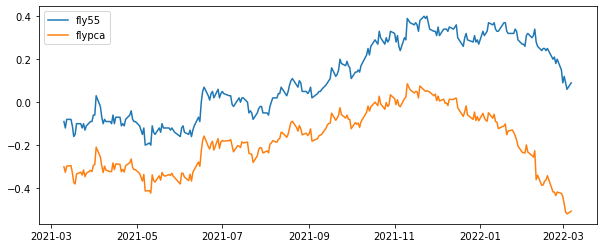

In [322]:
# def fly_pca_calc():

W = pd.DataFrame(pca_change.components_.T)
W.columns = [f'PC_{i+1}' for i in range(W.shape[1])]
W.index = tickers

# w ij = loading of ith tenor (s=short, b=belly, l=long) of PC j

w_s1 = W.loc[w_short, 'PC_1']
w_s2 = W.loc[w_short, 'PC_2']
w_s3 = W.loc[w_short, 'PC_3']

w_b1 = W.loc[belly, 'PC_1']
w_b2 = W.loc[belly, 'PC_2']
w_b3 = W.loc[belly, 'PC_3']

w_l1 = W.loc[w_long, 'PC_1']
w_l2 = W.loc[w_long, 'PC_2']
w_l3 = W.loc[w_long, 'PC_3']

fly55_1 = w_b1 - (w_s1 + w_l1) * 0.5 # PC1 exposure of 5050 fly e.g. if PC1 moved +1, your fly moves this amount in bps
fly55_2 = w_b2 - (w_s2 + w_l2) * 0.5 # PC2 exposure of 5050 fly

print(fly55_1, fly55_2)

# solve sim eq Ab = x to get PC1+2 neutral weights

A = np.array([[w_s1, w_l1],[w_s2, w_l2]])
b = np.array([w_b1, w_b2])
pca_short, pca_long = np.matmul(np.linalg.inv(A), b) # pca_short:1:pca_long
print('pca weights short/long \n',pca_short,pca_long)

flypca = df_daily_diff[belly]*1 - (pca_short*df_daily_diff[w_short] + pca_long*df_daily_diff[w_long])
plt.figure(figsize=(14,4));
plt.subplot(131);
sns.regplot(x=df_pca_change['PC_1'], y=flypca);
plt.subplot(132);
sns.regplot(x=df_pca_change['PC_2'], y=flypca);
plt.subplot(133);
sns.regplot(x=df_pca_change['PC_3'], y=flypca);

tsr_fly55 = df_daily[belly]*2 - (df_daily[w_short] + df_daily[w_long]) # conventional fly 1:2:1
tsr_flypca = df_daily[belly]*2 - (pca_short*df_daily[w_short] + pca_long*df_daily[w_long])*2
tsr = pd.concat([tsr_fly55, tsr_flypca], axis=1)
tsr.columns = ['fly55','flypca']

tsr.tail()

plt.figure(figsize=(10,4))
plt.plot(tsr);
plt.legend(tsr.columns, loc = "upper left");
plt.show()
